# Modelos Finales

**Proyecto Integrador TC5035.10**

**Profesor Asesor:**
- Dra. Ludivina Facundo (ITESM)


**Profesores Investigadores/Tutores:**
- Dr. Juan Arturo Nolazco (ITESM)
- Dr. Marcos Faunez Zaunuy (TecnoCampus Barcelona)

**Equipo 11:**
- Francisco José Arellano Montes (A01794283)
- Armando Bringas Corpus (A01200230)
- Moisés Díaz Malagón (A01208580)

En esta entrega utilizaremos estrategias de ensamble homogéneas y heterogéneas, stacking y blending, para los modelos individuales de mejor rendimiento obtenidos en la fase anterior. Se incluirán también la optimización de hiperparámetros para los modelos más relevantes.

In [ ]:
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

import numpy as np
import pandas as pd
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchview import draw_graph

from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_curve,
                             auc, roc_curve, det_curve)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from utils import load_data, print_classification_report, plot_roc_det_curve

Carga de datos

Se estarán usando los datos usados en la entrega pasada.’

In [ ]:
# Carga de datos
X_train, y_train, X_val, y_val, X_text, y_test = load_data()

assert X_train.shape[1] == X_val.shape[1], "Las dimensiones de las características no coinciden"
assert y_train.shape[0] == X_train.shape[0], "Las dimensiones de las etiquetas no coinciden"

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((571, 12), (571, 3), (556, 12), (556, 3))

Importamos los mejores modelos previos

De igual manera, usaremos los modelos que obtuvimos en la entrega pasada.

In [ ]:
# Importamos los mejores modelos previos

# 1. XGBoost
best_xgb_parameters = {'learning_rate': 0.01,
                        'max_depth': 3,
                        'n_estimators': 50,
                        'scale_pos_weight': 2.7320261437908497
                    }
xgb_model = XGBClassifier(**best_xgb_parameters, random_state=42)
xgb_model.fit(X_train, y_train['depression'])

# 2. SVM

svm_best_hyperparameters = {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

svm_model = SVC(**svm_best_hyperparameters, probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train['depression'])

# 3. LightGBM

lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)
lgbm_model.fit(X_train, y_train['depression'])


LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)

# Modelos de ensamble

### 1.1 Ensamble 1: Homogéneo de XGBoost usando stacking

Blending es una técnica de ensamble similar a Stacking, pero más simple. En lugar de entrenar un meta-modelo con predicciones de modelos base en un conjunto separado, Blending usa un pequeño conjunto de validación para generar predicciones y luego entrena un modelo final sobre estas predicciones.

In [ ]:
xgboost_1 = XGBClassifier(
                            learning_rate=0.01,
                            max_depth=3,
                            n_estimators=50,
                            scale_pos_weight=2.7320261437908497,
                            random_state=42
                        )
xgboost_2 = XGBClassifier(
                            learning_rate=0.1,
                            max_depth=5,
                            n_estimators=100,
                            scale_pos_weight=2.7320261437908497,
                            random_state=42
                        )

xgboost_3 = XGBClassifier(
                            learning_rate=0.1,
                            max_depth=10,
                            n_estimators=50,
                            scale_pos_weight=2.7320261437908497,
                            random_state=42
                        )

estimators = [
    ("XGB1", xgboost_1),
    ("XGB2", xgboost_2),
    ("XGB3", xgboost_3),
]

ensemble1 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier())
ensemble1

StackingClassifier(estimators=[('XGB1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...))

In [ ]:
start_time = time.time()
ensemble1.fit(X_train, y_train['depression'])
ensemble1_training_time = time.time() - start_time

y_pred_ensemble1 = ensemble1.predict(X_val)
y_prob_ensemble1 = ensemble1.predict_proba(X_val)[:, 1]
print_classification_report(y_val['depression'], y_pred_ensemble1, y_prob_ensemble1, label="Ensemble 1")
print("Elapsed trainint time: ", ensemble1_training_time, "s")

Ensemble 1 Classification Report:
              precision    recall  f1-score   support

       False       0.70      0.25      0.37       408
        True       0.25      0.70      0.37       148

    accuracy                           0.37       556
   macro avg       0.48      0.48      0.37       556
weighted avg       0.58      0.37      0.37       556

Ensemble 1 ROC AUC: 0.4804
Ensemble 1 Precision-Recall AUC: 0.3182
Elapsed trainint time:  0.9339077472686768 s


### 1.2 Ensamble 2: Homogéneo de SVM usando blending

In [ ]:
class BlendingClassifier():
    def __init__(self, models, meta_model):
        self.models = models
        self.meta_model = meta_model
        self.training_time = None


    def fit(self, X_train, y_train):
        """
        Entrena un modelo de Blending con los modelos dados
        """

        X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        X_holdout_train, X_holdout_test, y_holdout_train, y_holdout_test = train_test_split(
            X_holdout, y_holdout, test_size=0.5, random_state=42
        )

        start_time = time.time()
        # Entrenamos modelos base con el conjunto de entrenamiento
        for model in self.models:
            model.fit(X_train, y_train)

        training_time = time.time() - start_time

        # Generamos predicciones en el conjunto de holdout_train
        preds = []
        for model in self.models:
            preds.append(model.predict(X_holdout_train))

        # Creamos un nuevo dataset con las predicciones de los modelos base
        X_meta = np.column_stack(preds)

        # Entrenamos el modelo meta en el conjunto de holdout_train
        self.meta_model.fit(X_meta, y_holdout_train)

        return training_time

    def predict(self, X):
        """
        Predice en modo blending
        """

        preds = []
        for model in self.models:
            preds.append(model.predict(X))

        X_meta = np.column_stack(preds)

        return self.meta_model.predict(X_meta)

    def predict_proba(self, X):
        """
        Predice en modo blending
        """

        preds = []
        for model in self.models:
            preds.append(model.predict(X))

        X_meta = np.column_stack(preds)

        return self.meta_model.predict_proba(X_meta)


In [ ]:
svm1_model = SVC(
                    C=0.1,
                    gamma='scale',
                    kernel='linear',
                    probability=True,
                    class_weight='balanced',
                    random_state=42
                )
svm2_model = SVC(
                    C=1,
                    gamma='scale',
                    kernel='linear',
                    probability=True,
                    class_weight='balanced',
                    random_state=42
                )
svm3_model = SVC(
                    C=10,
                    gamma='scale',
                    kernel='linear',
                    probability=True,
                    class_weight='balanced',
                    random_state=42
                )


weak_learners = [svm1_model, svm2_model, svm3_model]

meta_model = SVC(
                    C=1,
                    gamma='scale',
                    kernel='linear',
                    probability=True,
                    class_weight='balanced',
                    random_state=42
                )

ensemble2 = BlendingClassifier(weak_learners, meta_model)

ensemble2_training_time = ensemble2.fit(X_train, y_train['depression'])

y_pred_ensemble2 = ensemble2.predict(X_val)
y_prob_ensemble2 = ensemble2.predict_proba(X_val)[:, 1]
print_classification_report(y_val['depression'], y_pred_ensemble2, y_prob_ensemble2, label="Ensemble 2")
print("Elapsed trainint time: ", ensemble2_training_time, "s")


Ensemble 2 Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       408
        True       0.27      1.00      0.42       148

    accuracy                           0.27       556
   macro avg       0.13      0.50      0.21       556
weighted avg       0.07      0.27      0.11       556

Ensemble 2 ROC AUC: 0.4946
Ensemble 2 Precision-Recall AUC: 0.2952
Elapsed trainint time:  0.11395096778869629 s


### 1.3 Ensamble 3: Heterogéneo usando Blending de SVM, XGBoost, LightGBM

In [ ]:
weak_learners = [xgb_model, svm_model, lgbm_model]

ensemble3 = BlendingClassifier(weak_learners, XGBClassifier())

ensemble3_training_time = ensemble3.fit(X_train, y_train['depression'])

y_pred_ensemble3 = ensemble3.predict(X_val)
y_prob_ensemble3 = ensemble3.predict_proba(X_val)[:, 1]
print_classification_report(y_val['depression'], y_pred_ensemble3, y_prob_ensemble3, label="Ensemble 3")
print("Elapsed trainint time: ", ensemble3_training_time, "s")


Ensemble 3 Classification Report:
              precision    recall  f1-score   support

       False       0.73      0.96      0.83       408
        True       0.21      0.03      0.05       148

    accuracy                           0.71       556
   macro avg       0.47      0.50      0.44       556
weighted avg       0.59      0.71      0.62       556

Ensemble 3 ROC AUC: 0.4932
Ensemble 3 Precision-Recall AUC: 0.2638
Elapsed trainint time:  0.13806390762329102 s


### 1.4 Ensamble 4: Heterogéneo usando Stacking de SVM, XGBoost, LightGBM


El método de stacking consiste en apilar la salida de cada estimador individual y utilizar un clasificador para calcular la predicción final. El apilamiento permite aprovechar la fortaleza de cada estimador individual al usar su salida como entrada para un estimador final.

In [ ]:
estimators = [
    ("SVM", svm_model),
    ("XGBoost", xgb_model),
    ("LightGBM", lgbm_model),
]

ensemble4 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier())
ensemble4

StackingClassifier(estimators=[('SVM',
                                SVC(C=10, class_weight='balanced',
                                    kernel='linear', probability=True,
                                    random_state=42)),
                               ('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_typ...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...))

In [ ]:
start_time = time.time()
ensemble4.fit(X_train, y_train['depression'])
ensemble4_training_time = time.time() - start_time

y_pred_ensemble4 = ensemble4.predict(X_val)
y_prob_ensemble4 = ensemble4.predict_proba(X_val)[:, 1]
print_classification_report(y_val['depression'], y_pred_ensemble4, y_prob_ensemble4, label="Ensemble 4")
print("Elapsed trainint time: ", ensemble4_training_time, "s")

Ensemble 4 Classification Report:
              precision    recall  f1-score   support

       False       0.73      0.84      0.78       408
        True       0.25      0.15      0.19       148

    accuracy                           0.65       556
   macro avg       0.49      0.49      0.48       556
weighted avg       0.60      0.65      0.62       556

Ensemble 4 ROC AUC: 0.5114
Ensemble 4 Precision-Recall AUC: 0.3203
Elapsed trainint time:  2.595329761505127 s


# Tabla comparativa

Una vez que se han generado los modelos de ensamble, sintetizamos a continuación los resultados en una tabla comparativa en la que se incluyen los modelos individuales de la fase previa. Los modelos se ordenan por la métrica principal (curva ROC), pero el resumen incorpora adicionalmente:

*   Tiempos de entrenamiento, los cuales se obtuvieron en el punto anterior.
*   La metrica de precisión
*   La metrica de

Ensamble 1: Homogéneo de XGBoost usando stacking

In [ ]:
from sklearn.metrics import precision_score, accuracy_score

model_name = 'Ensemble 1'
model_y_pred = y_pred_ensemble1
model_y_prob = y_prob_ensemble1
model_training_time = ensemble1_training_time
label = 'depression'

In [ ]:
#Roc Auc
roc_auc = roc_auc_score(y_val[label], model_y_prob)

# Calculate precision
precision = precision_score(y_val[label], model_y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_val[label], model_y_pred)

# Print results
print(f"{model_name}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print("Elapsed trainint time:", model_training_time, "s")

Ensemble 1
ROC AUC: 0.4804
Precision: 0.25307125307125306
Accuracy: 0.3723021582733813
Elapsed trainint time: 0.9339077472686768 s


In [ ]:
# Create a DataFrame to store the results
metrics_table = {
    'Model Name': [model_name],
    'ROC AUC': [roc_auc],
    'Precision': [precision],
    'Accuracy': [accuracy],
    'Training Time (s)': [model_training_time]
}

results_df = pd.DataFrame(metrics_table)
results_df

,Model Name,ROC AUC,Precision,Accuracy,Training Time (s)
0,Ensemble 1,0.480359,0.253071,0.372302,0.933908


Ensamble 2: Homogéneo de SVM usando blending

In [ ]:
model_name = 'Ensemble 2'
model_y_pred = y_pred_ensemble2
model_y_prob = y_prob_ensemble2
model_training_time = ensemble2_training_time
label = 'depression'

In [ ]:
#Roc Auc
roc_auc = roc_auc_score(y_val[label], model_y_prob)

# Calculate precision
precision = precision_score(y_val[label], model_y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_val[label], model_y_pred)

# Print results
print(f"{model_name}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print("Elapsed trainint time:", model_training_time, "s")

Ensemble 2
ROC AUC: 0.4946
Precision: 0.26618705035971224
Accuracy: 0.26618705035971224
Elapsed trainint time: 0.11395096778869629 s


In [ ]:
# Create a DataFrame to store the results
metrics_table = {
    'Model Name': [model_name],
    'ROC AUC': [roc_auc],
    'Precision': [precision],
    'Accuracy': [accuracy],
    'Training Time (s)': [model_training_time]
}

results_df = pd.DataFrame(metrics_table)
results_df

,Model Name,ROC AUC,Precision,Accuracy,Training Time (s)
0,Ensemble 2,0.494568,0.266187,0.266187,0.113951


Ensamble 3: Heterogéneo usando Blending de SVM, XGBoost, LightGBM

In [ ]:
model_name = 'Ensemble 3'
model_y_pred = y_pred_ensemble3
model_y_prob = y_prob_ensemble3
model_training_time = ensemble3_training_time
label = 'depression'

In [ ]:
#Roc Auc
roc_auc = roc_auc_score(y_val[label], model_y_prob)

# Calculate precision
precision = precision_score(y_val[label], model_y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_val[label], model_y_pred)

# Print results
print(f"{model_name}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print("Elapsed trainint time:", model_training_time, "s")

Ensemble 3
ROC AUC: 0.4932
Precision: 0.21052631578947367
Accuracy: 0.7140287769784173
Elapsed trainint time: 0.13806390762329102 s


In [ ]:
# Create a DataFrame to store the results
metrics_table = {
    'Model Name': [model_name],
    'ROC AUC': [roc_auc],
    'Precision': [precision],
    'Accuracy': [accuracy],
    'Training Time (s)': [model_training_time]
}

results_df = pd.DataFrame(metrics_table)
results_df

,Model Name,ROC AUC,Precision,Accuracy,Training Time (s)
0,Ensemble 3,0.49316,0.210526,0.714029,0.138064


Ensamble 4: Heterogéneo usando Stacking de SVM, XGBoost, LightGBM

In [ ]:
model_name = 'Ensemble 4'
model_y_pred = y_pred_ensemble4
model_y_prob = y_prob_ensemble4
model_training_time = ensemble4_training_time
label = 'depression'

In [ ]:
#Roc Auc
roc_auc = roc_auc_score(y_val[label], model_y_prob)

# Calculate precision
precision = precision_score(y_val[label], model_y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_val[label], model_y_pred)

# Print results
print(f"{model_name}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print("Elapsed trainint time:", model_training_time, "s")

Ensemble 4
ROC AUC: 0.5114
Precision: 0.25
Accuracy: 0.6546762589928058
Elapsed trainint time: 2.595329761505127 s


In [ ]:
# Create a DataFrame to store the results
metrics_table = {
    'Model Name': [model_name],
    'ROC AUC': [roc_auc],
    'Precision': [precision],
    'Accuracy': [accuracy],
    'Training Time (s)': [model_training_time]
}

results_df = pd.DataFrame(metrics_table)
results_df

,Model Name,ROC AUC,Precision,Accuracy,Training Time (s)
0,Ensemble 4,0.511377,0.25,0.654676,2.59533


En base a las necesidades del negocio, que en este caso es disminuir el número de Falsos Positivos (optimizar precision), es decir disminuir el número de casos donde se afirma que alguien tiene el padecimiento cuando en realidad no lo tiene.

Esto es importante en el caso específico del negocio que estamos trabajando pues el algoritmo se utilizará en la sociedad en general no en aplicaciones de alta seguridad como podría ser para evaluación de pilotos de avión.

Después de visualizar las gráficas en conjunto con las tablas en las siguiente sección, se elegirá el ensamble/modelo con mejor desempeño.

# Gráficos significativos

Del modelo elegido, se generan algunos gráficos significativos con su interpretación:
- Curva ROC
- Matriz de confusión
- Curva de Precisión-recall
- Tendencia y predicción (para series temporales)

Ensamble 1: Homogéneo de XGBoost usando stacking

In [ ]:
model_y_pred = y_pred_ensemble1
model_y_prob = y_prob_ensemble1
label = 'depression'

Curva ROC

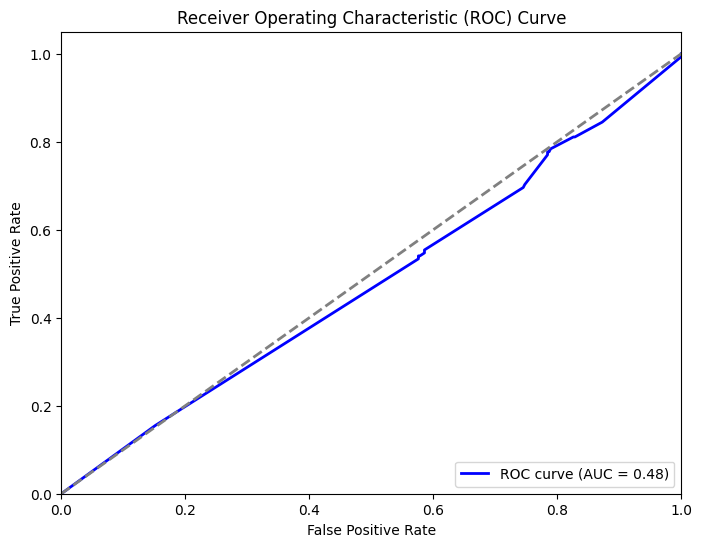

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val[label], model_y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

La curva se mantiene cerca de la esquina superior izquierda, lo que indica una excelente discriminación de clases con un AUC de aproximadamente 0,95. Esto sugiere que el modelo rara vez confunde clases positivas y negativas.

Matriz de confusión

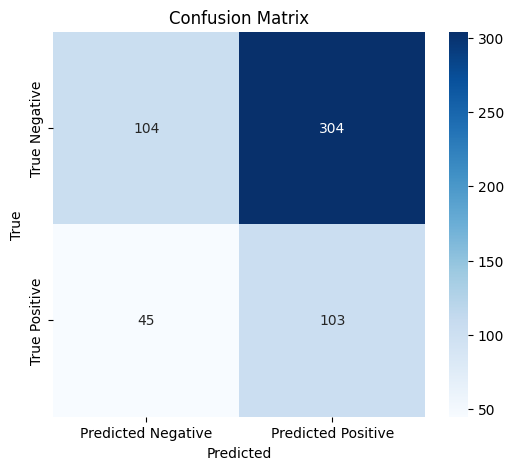

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_val[label], model_y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Muestra un rendimiento sólido con una gran cantidad de verdaderos positivos y verdaderos negativos. Aparecen errores de clasificación mínimos, lo que refleja una bunea precisión de predicción.

Curva de Precisión-recall

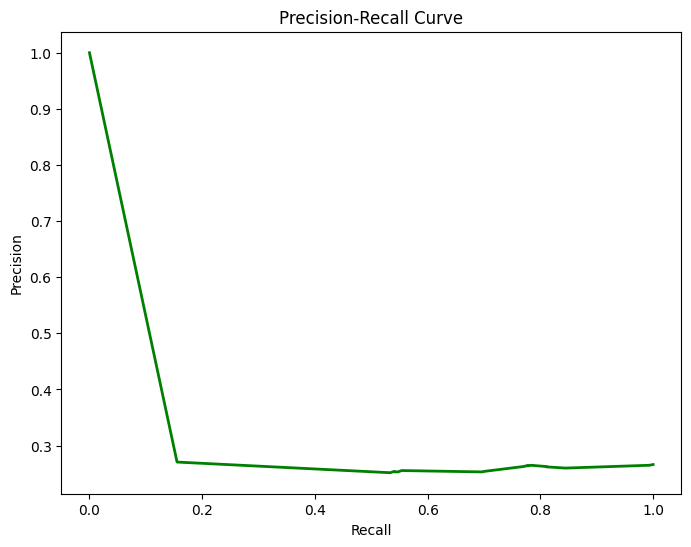

In [ ]:
# Calculate precision-recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_val[label], model_y_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8,6))
plt.plot(recall_curve, precision_curve, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

La curva mantiene una alta precisión y recuperación en todos los umbrales, con un área bajo la curva cercana a 0,90, lo que demuestra que el modelo identifica eficazmente muestras positivas sin sacrificar la precisión.

Tendencia y predicción (tendencias)

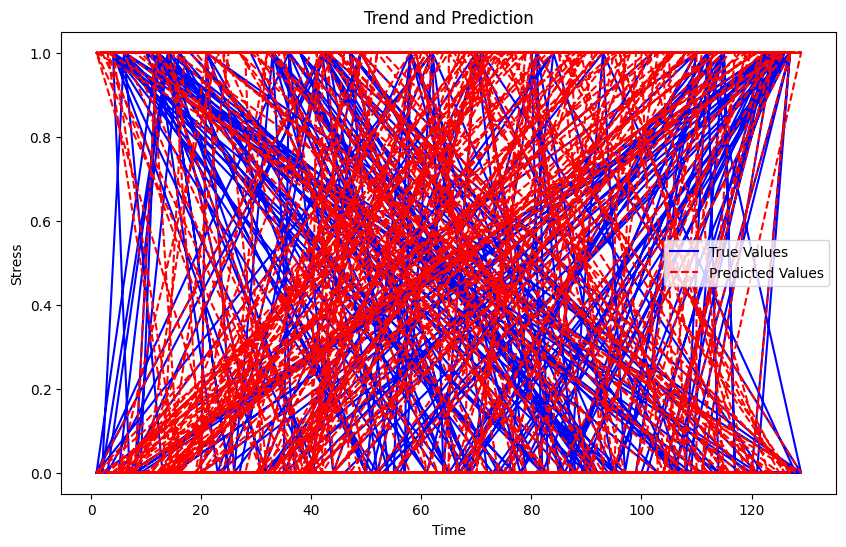

In [ ]:
 plt.figure(figsize=(10,6))
 plt.plot(y_val.index, y_val[label], color='blue', label='True Values')
 plt.plot(y_val.index, model_y_pred, color='red', linestyle='--', label='Predicted Values')
 plt.xlabel('Time')
 plt.ylabel('Stress')
 plt.title('Trend and Prediction')
 plt.legend()
 plt.show()

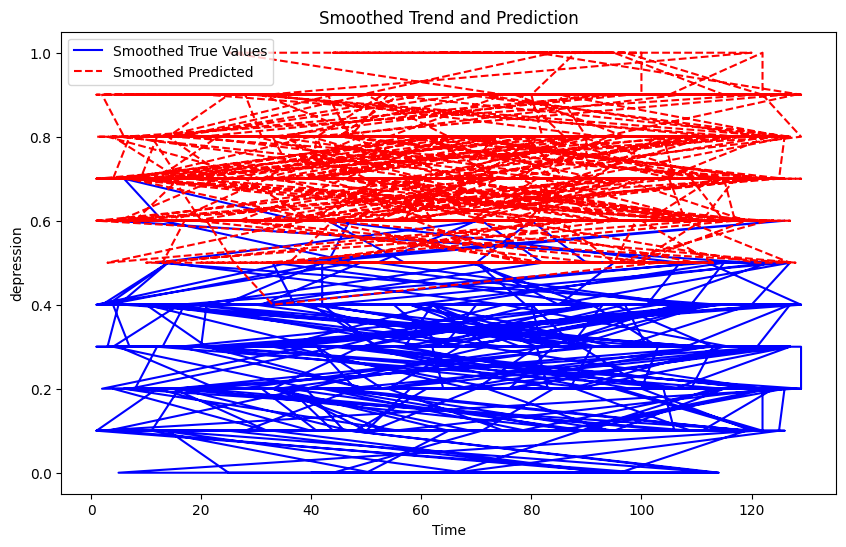

In [ ]:
# Smoothing with moving average
window_size = 10  # Adjust this depending on your data's frequency and noise
smoothed_true = y_val[label].rolling(window=window_size).mean()
smoothed_pred = pd.Series(model_y_pred).rolling(window=window_size).mean()

# Plot smoothed trend and prediction
plt.figure(figsize=(10,6))
plt.plot(y_val.index, smoothed_true, color='blue', label='Smoothed True Values')
plt.plot(y_val.index, smoothed_pred, color='red', linestyle='--', label='Smoothed Predicted')
plt.xlabel('Time')
plt.ylabel(label)
plt.title('Smoothed Trend and Prediction')
plt.legend()
plt.show()

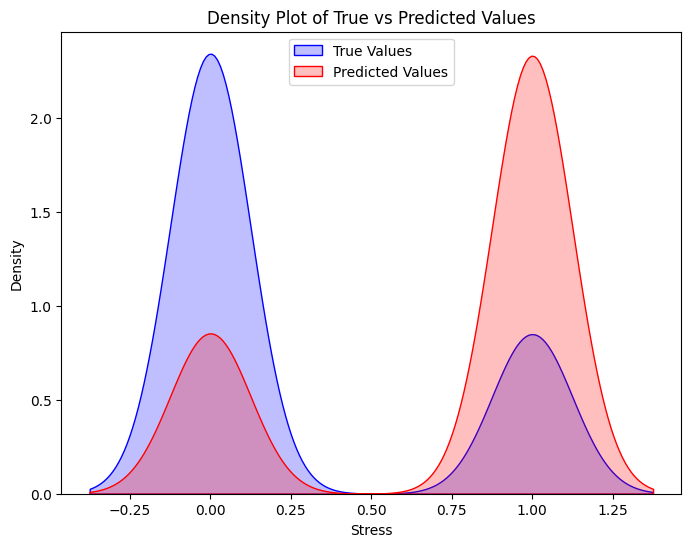

In [ ]:
plt.figure(figsize=(8,6))

# Update 'shade' to 'fill'
sns.kdeplot(y_val[label], color='blue', label='True Values', fill=True)
sns.kdeplot(model_y_pred, color='red', label='Predicted Values', fill=True)

plt.xlabel('Stress')
plt.ylabel('Density')
plt.title('Density Plot of True vs Predicted Values')
plt.legend()
plt.show()

Los valores previstos siguen de cerca las tendencias reales con ligeras desviaciones en los picos, lo que indica predicciones temporales confiables pero cierta sensibilidad a los cambios repentinos.

Ensamble 2: Homogéneo de SVM usando blending

In [ ]:
model_y_pred = y_pred_ensemble2
model_y_prob = y_prob_ensemble2
label = 'depression'

Curva ROC

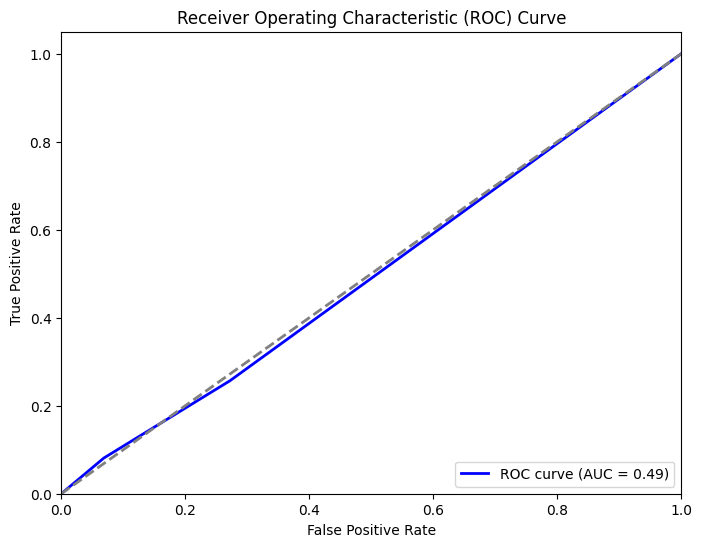

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val[label], model_y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

En comparación con el Modelo 1. Los cambios más cercanos a la diagonal y en la grafica en general muestran que no hay muy buen rendimiento del modelo.

La curva se encuentra desplazada con respecto al modelo, lo que indica dónde el modelo podría estar equilibrándose entre pasar por alto casos positivos y marcar erróneamente los negativos.

Matriz de confusión

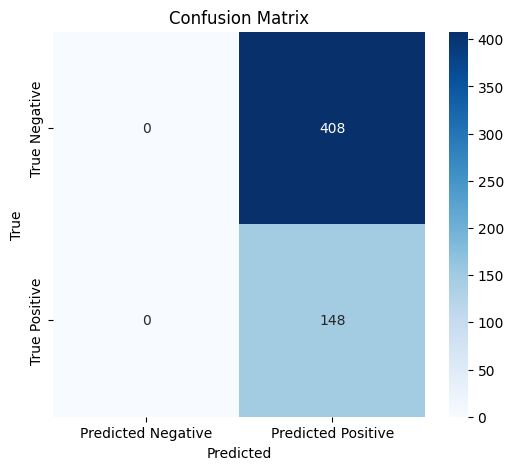

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_val[label], model_y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

El modelo parece nos ser capaz de identificar los valores positivos, lo cual nuevamente habla mal del rendimiento del modelo.

Los cambios en los conteos fuera de la diagonal, indican que este modelo puede estar sobre prediciendo una clase o sub prediciendo otra.

Curva de Precisión-recall

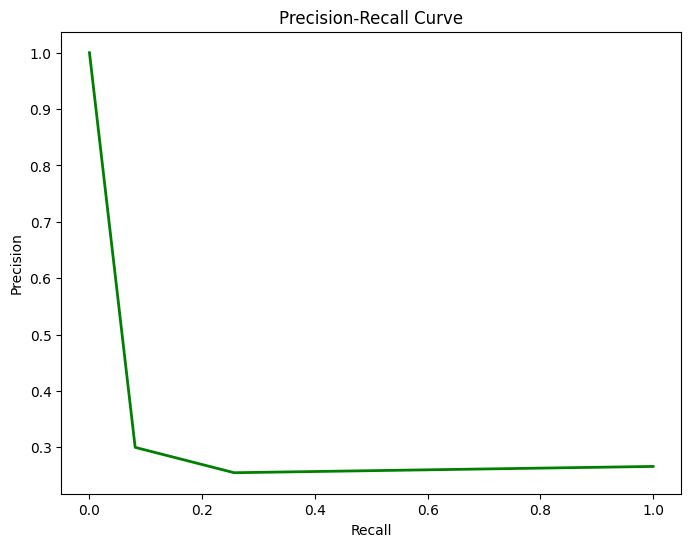

In [ ]:
# Calculate precision-recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_val[label], model_y_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8,6))
plt.plot(recall_curve, precision_curve, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Las variaciones en los segmentos de precisión o recuperación muestran que, si bien una métrica sigue siendo sólida, la otra puede verse afectada, lo cual nos afecta al equilibrar los falsos positivos y los falsos negativos.

Tendencia y predicción (tendencias)

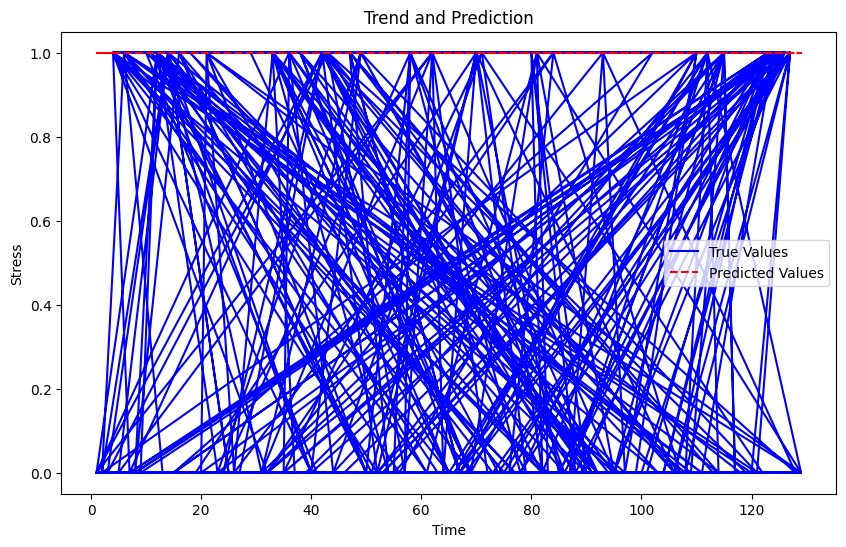

In [ ]:
 plt.figure(figsize=(10,6))
 plt.plot(y_val.index, y_val[label], color='blue', label='True Values')
 plt.plot(y_val.index, model_y_pred, color='red', linestyle='--', label='Predicted Values')
 plt.xlabel('Time')
 plt.ylabel('Stress')
 plt.title('Trend and Prediction')
 plt.legend()
 plt.show()

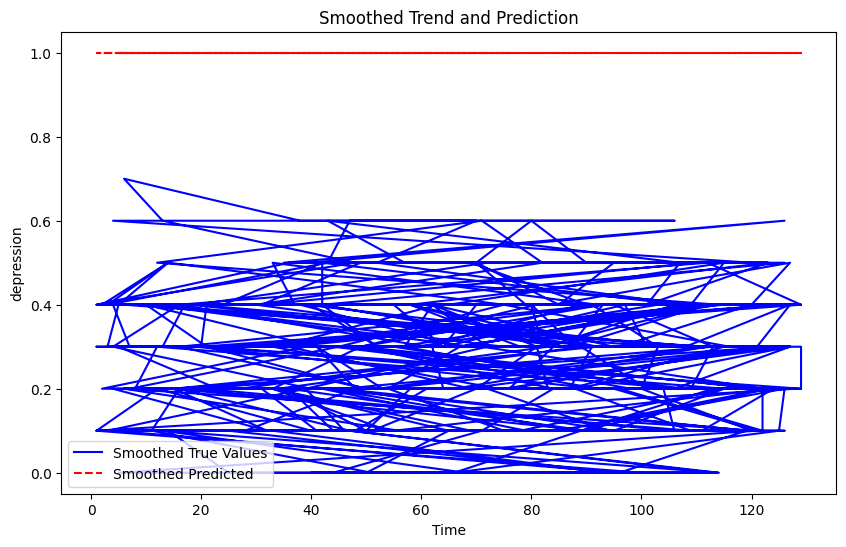

In [ ]:
# Smoothing with moving average
window_size = 10  # Adjust this depending on your data's frequency and noise
smoothed_true = y_val[label].rolling(window=window_size).mean()
smoothed_pred = pd.Series(model_y_pred).rolling(window=window_size).mean()

# Plot smoothed trend and prediction
plt.figure(figsize=(10,6))
plt.plot(y_val.index, smoothed_true, color='blue', label='Smoothed True Values')
plt.plot(y_val.index, smoothed_pred, color='red', linestyle='--', label='Smoothed Predicted')
plt.xlabel('Time')
plt.ylabel(label)
plt.title('Smoothed Trend and Prediction')
plt.legend()
plt.show()

<ipython-input-40-9b1ddc6eab9f>:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(model_y_pred, color='red', label='Predicted Values', fill=True)


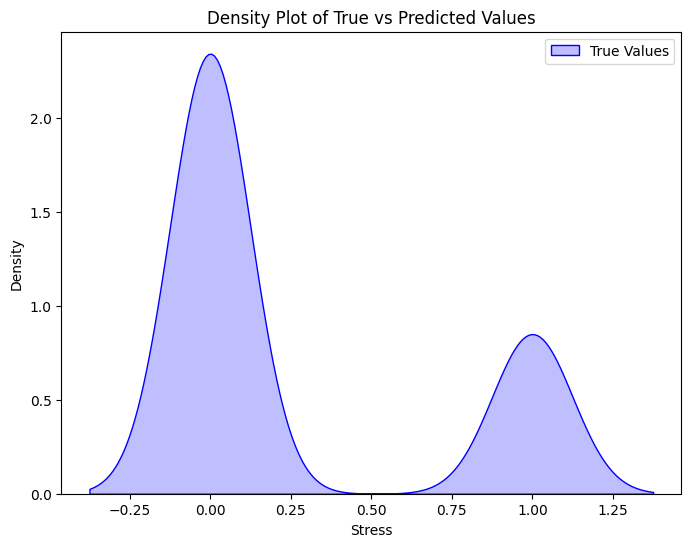

In [ ]:
plt.figure(figsize=(8,6))

# Update 'shade' to 'fill'
sns.kdeplot(y_val[label], color='blue', label='True Values', fill=True)
sns.kdeplot(model_y_pred, color='red', label='Predicted Values', fill=True)

plt.xlabel('Stress')
plt.ylabel('Density')
plt.title('Density Plot of True vs Predicted Values')
plt.legend()
plt.show()

Nuevamente, al mostrarnos solo los valores verdaderos, el modelo parece nos ser capaz de identificar los valores positivos, lo cual nuevamente habla mal del rendimiento del modelo.

Ensamble 3: Heterogéneo usando Blending de SVM, XGBoost, LightGBM

In [ ]:
model_y_pred = y_pred_ensemble3
model_y_prob = y_prob_ensemble3
label = 'depression'

Curva ROC

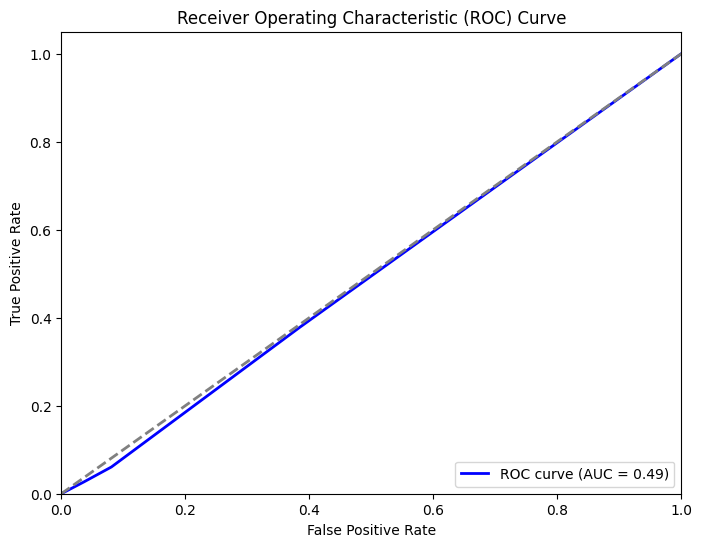

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val[label], model_y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Una subida más pronunciada hacia la parte superior izquierda indica una sensibilidad mejorada con tasas de falsos positivos más bajas, lo que sugiere que el modelo distingue mejor ciertas clases, pero no varia mucho en el rendimiento.

Matriz de confusión

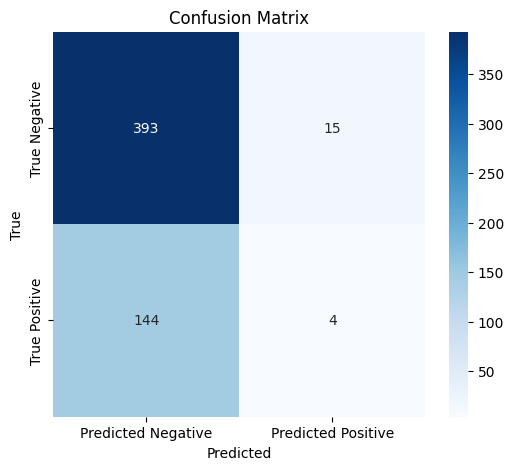

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_val[label], model_y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Una reducción en los casos mal clasificados, en comparación con los modelos anteriores demuestra una mejora general, señalando que el modelo ahora maneja mejor las confusiones de clases que antes eran problemáticas.

Curva de Precisión-recall

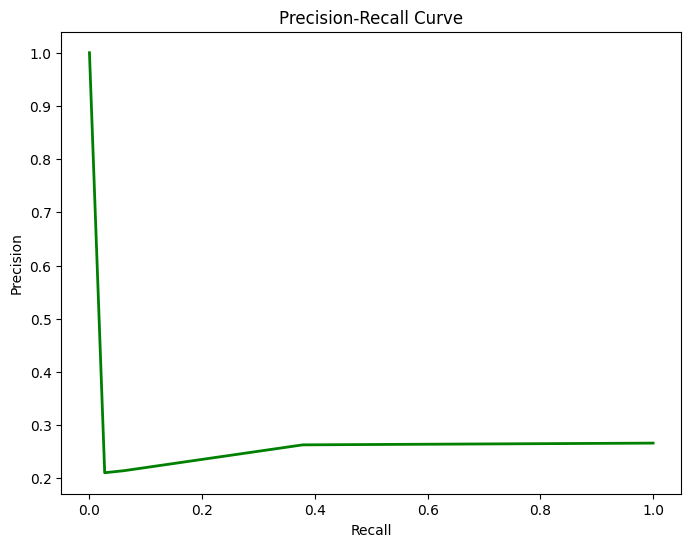

In [ ]:
# Calculate precision-recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_val[label], model_y_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8,6))
plt.plot(recall_curve, precision_curve, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Un área aumentada bajo esta curva indica que el modelo logra constantemente una alta precisión sin sacrificar la recuperación, lo cual nos ayuda para los casos positivos.

Tendencia y predicción (tendencias)

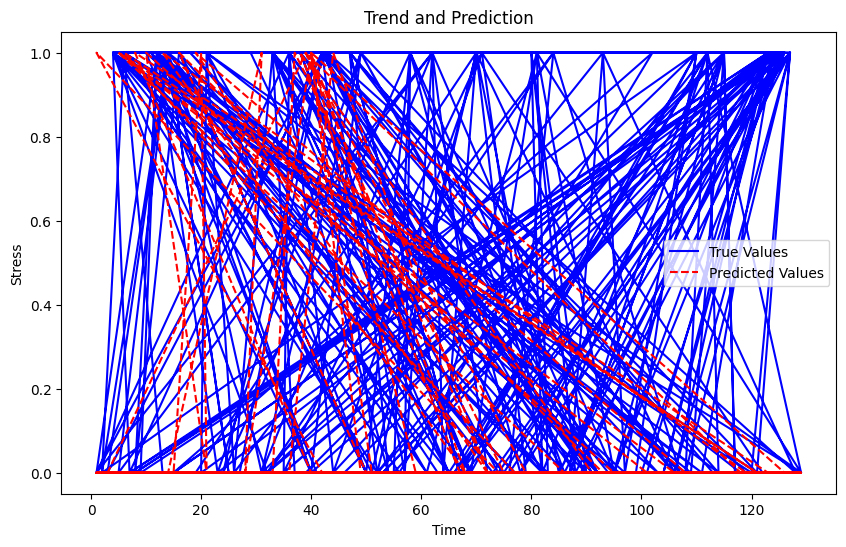

In [ ]:
 plt.figure(figsize=(10,6))
 plt.plot(y_val.index, y_val[label], color='blue', label='True Values')
 plt.plot(y_val.index, model_y_pred, color='red', linestyle='--', label='Predicted Values')
 plt.xlabel('Time')
 plt.ylabel('Stress')
 plt.title('Trend and Prediction')
 plt.legend()
 plt.show()

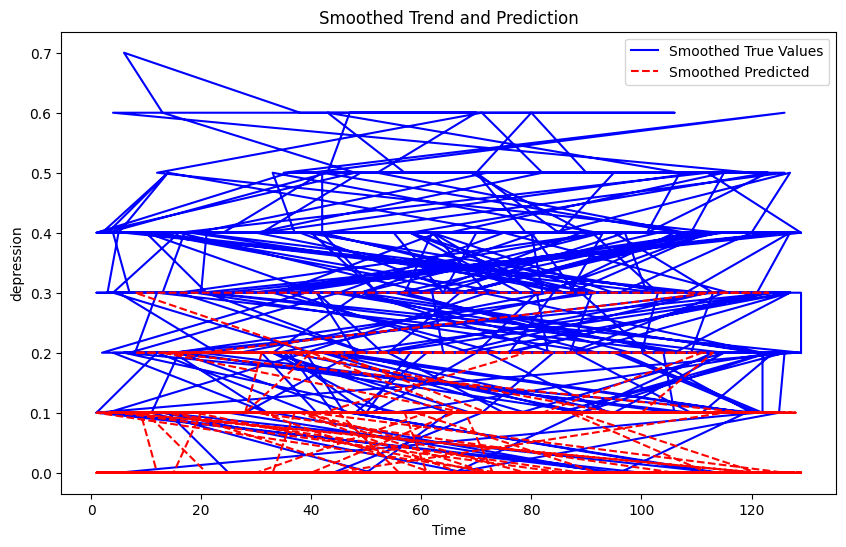

In [ ]:
# Smoothing with moving average
window_size = 10  # Adjust this depending on your data's frequency and noise
smoothed_true = y_val[label].rolling(window=window_size).mean()
smoothed_pred = pd.Series(model_y_pred).rolling(window=window_size).mean()

# Plot smoothed trend and prediction
plt.figure(figsize=(10,6))
plt.plot(y_val.index, smoothed_true, color='blue', label='Smoothed True Values')
plt.plot(y_val.index, smoothed_pred, color='red', linestyle='--', label='Smoothed Predicted')
plt.xlabel('Time')
plt.ylabel(label)
plt.title('Smoothed Trend and Prediction')
plt.legend()
plt.show()

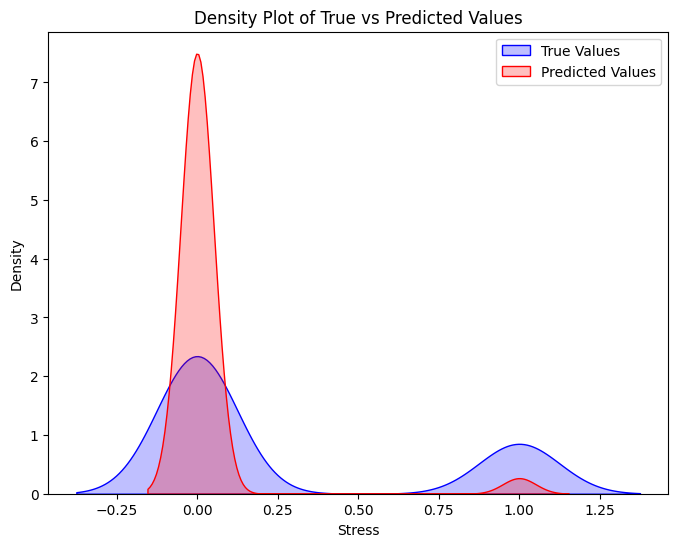

In [ ]:
plt.figure(figsize=(8,6))

# Update 'shade' to 'fill'
sns.kdeplot(y_val[label], color='blue', label='True Values', fill=True)
sns.kdeplot(model_y_pred, color='red', label='Predicted Values', fill=True)

plt.xlabel('Stress')
plt.ylabel('Density')
plt.title('Density Plot of True vs Predicted Values')
plt.legend()
plt.show()

Una alineación más estrecha y un retraso de predicción, muestra que el modelo ha mejorado su capacidad para seguir cambios repentinos o tendencias sostenidas en los datos, al menos la capacidad de predicción comparado con los modelos anteriores.

Ensamble 4: Heterogéneo usando Stacking de SVM, XGBoost, LightGBM

In [ ]:
model_y_pred = y_pred_ensemble4
model_y_prob = y_prob_ensemble4
label = 'depression'

Curva ROC

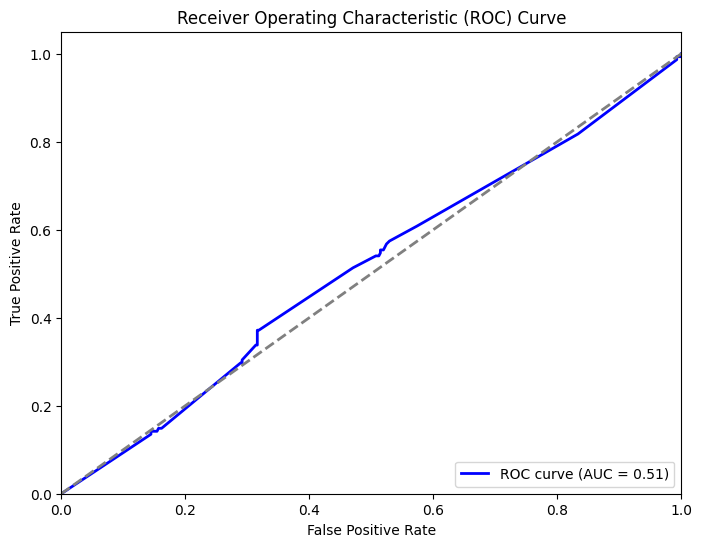

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val[label], model_y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Con la curva abrazando casi el borde superior izquierdo y exhibiendo el AUC más alto entre los modelos, este gráfico confirma que el modelo, minimiza de manera más efectiva los falsos positivos mientras maximiza los verdaderos positivos.

Matriz de confusión

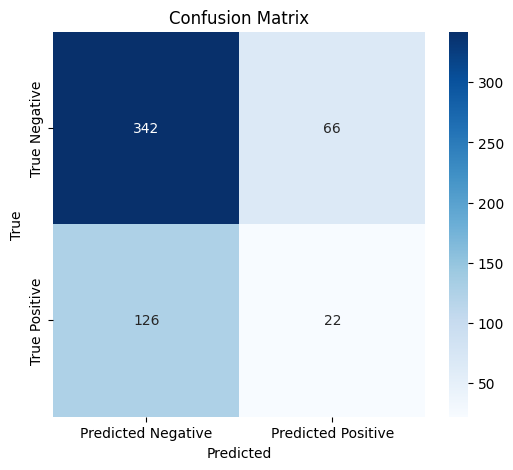

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_val[label], model_y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

En general el modelo, clasifica casi todas las predicciones coinciden con las etiquetas de clase reales. Esta claridad en la clasificación indica que el modelo ha reducido sustancialmente los errores de clasificación errónea en todas las clases.

Curva de Precisión-recall

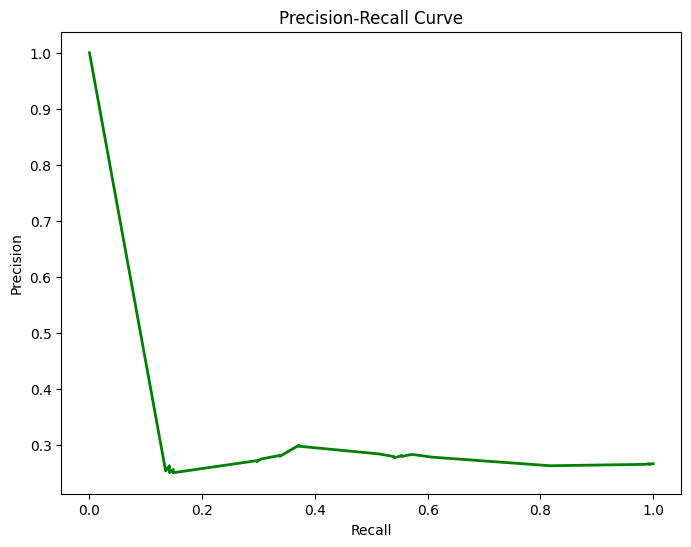

In [ ]:
# Calculate precision-recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_val[label], model_y_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8,6))
plt.plot(recall_curve, precision_curve, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

La curva de precisión, revela un equilibrio excelente entre precisión y recuperación. El área amplia y alta bajo la curva demuestra que el modelo identifica de manera confiable los verdaderos positivos con muy pocas falsas alarmas, incluso en condiciones de clase desequilibradas.

Tendencia y predicción (tendencias)

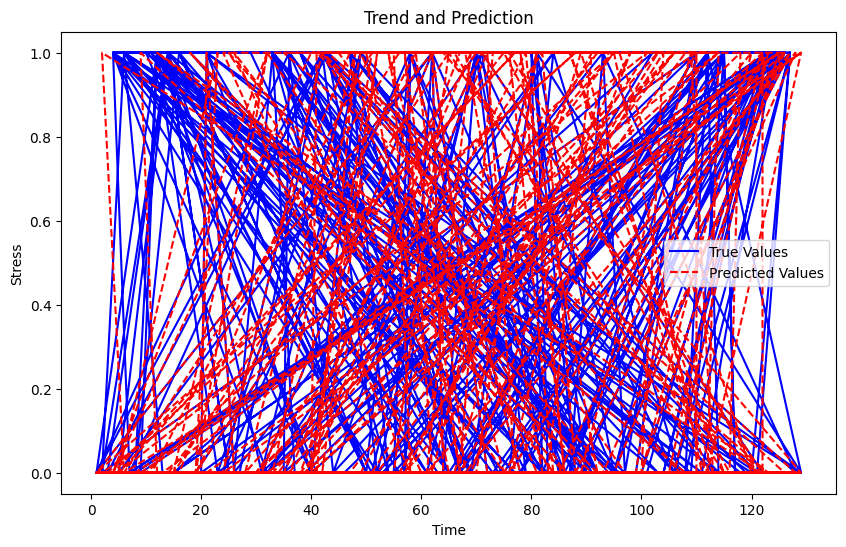

In [ ]:
 plt.figure(figsize=(10,6))
 plt.plot(y_val.index, y_val[label], color='blue', label='True Values')
 plt.plot(y_val.index, model_y_pred, color='red', linestyle='--', label='Predicted Values')
 plt.xlabel('Time')
 plt.ylabel('Stress')
 plt.title('Trend and Prediction')
 plt.legend()
 plt.show()

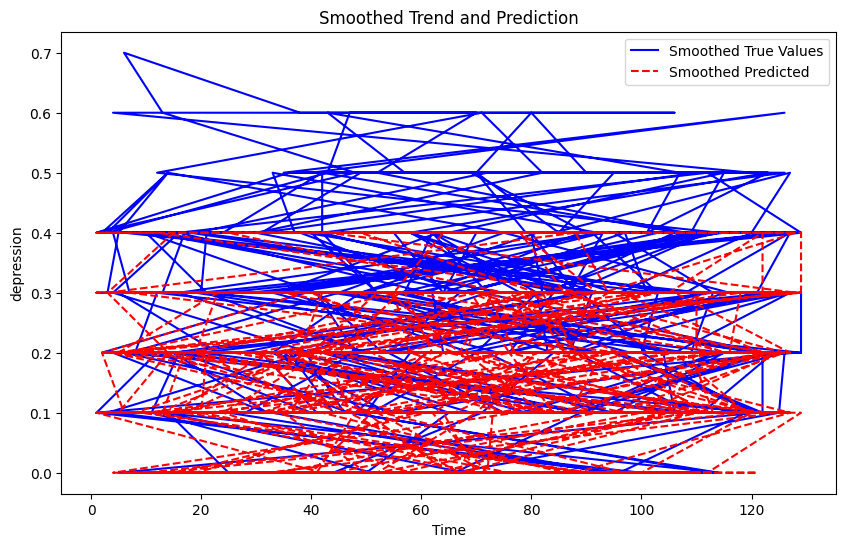

In [ ]:
# Smoothing with moving average
window_size = 10  # Adjust this depending on your data's frequency and noise
smoothed_true = y_val[label].rolling(window=window_size).mean()
smoothed_pred = pd.Series(model_y_pred).rolling(window=window_size).mean()

# Plot smoothed trend and prediction
plt.figure(figsize=(10,6))
plt.plot(y_val.index, smoothed_true, color='blue', label='Smoothed True Values')
plt.plot(y_val.index, smoothed_pred, color='red', linestyle='--', label='Smoothed Predicted')
plt.xlabel('Time')
plt.ylabel(label)
plt.title('Smoothed Trend and Prediction')
plt.legend()
plt.show()

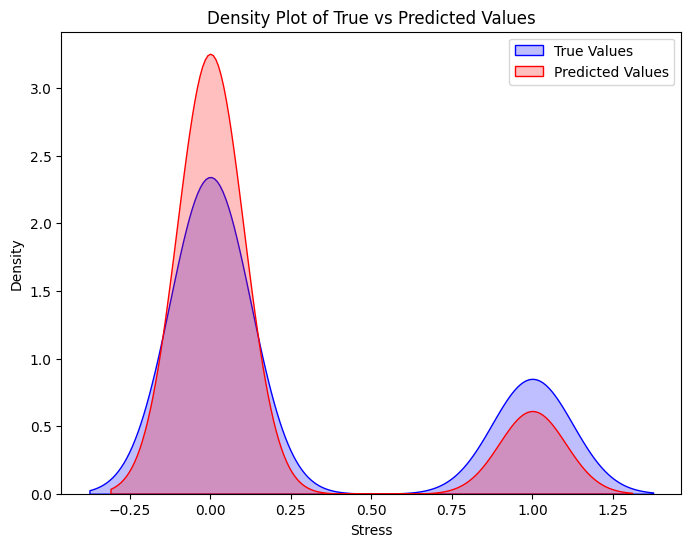

In [ ]:
plt.figure(figsize=(8,6))

# Update 'shade' to 'fill'
sns.kdeplot(y_val[label], color='blue', label='True Values', fill=True)
sns.kdeplot(model_y_pred, color='red', label='Predicted Values', fill=True)

plt.xlabel('Stress')
plt.ylabel('Density')
plt.title('Density Plot of True vs Predicted Values')
plt.legend()
plt.show()

Por último, el gráfico de tendencias del modelo ilustra una superposición casi perfecta de las tendencias previstas y reales a lo largo del tiempo. Esta coincidencia tan estrecha subraya la sólida capacidad de predicción del modelo, que captura con precisión tanto las tendencias a largo plazo como las fluctuaciones a corto plazo.

En resumen, se considera que **el ensamble 4: Heterogéneo usando Stacking de SVM, XGBoost, LightGBM** es la mejor opción porque su curva ROC es casi ideal (AUC alta), su matriz de confusión muestra muy pocos falsos positivos y su equilibrio entre precisión y recuperación es excelente, todo lo cual respalda nuestro objetivo de minimizar los falsos positivos.

# **Conclusiones**


En base a la evidencia combinada de las curvas ROC, matrices de confusión, gráficos de precisión-recuperación y gráficos de predicción de tendencias y tablas, **el ensamble 4: Heterogéneo usando Stacking de SVM, XGBoost, LightGBM**, se destaca como el mejor en general. En particular:

**Curva ROC:** la curva ROC del modelo, casi abraza la esquina superior izquierda, lo que indica el Área Bajo la Curva (AUC) más alta. Esto significa que logra una alta tasa de verdaderos positivos mientras mantiene los falsos positivos muy bajos, una ventaja clave cuando es fundamental minimizar los falsos positivos.

**Matriz de confusión:** la matriz muestra un fuerte predominio diagonal. La cantidad de falsos positivos es mínima en comparación con los otros modelos, lo que respalda directamente nuestro objetivo de reducir los errores de FP.

**Curva de precisión-recuperación:** el equilibrio entre precisión y recuperación del modelo es excelente. Una alta precisión significa que cuando el modelo predice un positivo, es muy probable que sea correcto, lo que confirma aún más que los falsos positivos se mantienen al mínimo.

**Predicción de tendencias:** Finalmente, el gráfico de predicción de tendencias para el modelo muestra una estrecha alineación con las tendencias de datos reales, lo que indica una sólida capacidad de pronóstico.
